<a href="https://colab.research.google.com/github/aryafridayana/Machine-Learning/blob/Task-Week-10/week-10/BostonHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Arya Fridayana Gastiadi
###1103210082
###Deep Learning
###bostonhousingdataset
###DokumentasiChatGPT: https://chatgpt.com/share/7dd76c93-4b78-449e-b4ea-08e2192e95d0

In [1]:
# Pasang paket d2l
!pip install d2l

#Memuat Library

In [2]:
from d2l import torch as d2l
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F

#Mengunduh dataset

In [3]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

#Memuat Dataset

In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


#Pemerosesan

In [5]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [7]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [8]:
data.preprocess()
data.train.shape

(1460, 331)

#Mengecek Kesalahan

In [9]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

#Memvalidasi K-FOLD

In [10]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [11]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

#Seleksi Model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functi

average validation log mse = 0.17871095597743988


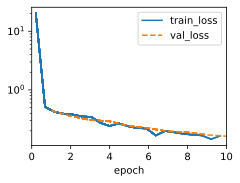

In [12]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)